In [3]:
# /home/mbd1234/yolact/utils/augmentations.py의 Resize 클래스와 메서드 내용을 확인합니다.
# 경로에 맞게 import하고 help, print 등으로 내부를 확인합니다.

import sys
sys.path.append('/home/mbd1234')

from utils.augmentations import Resize

# 클래스 자체 확인
print("Resize 클래스:", Resize)

# docstring과 메서드 목록 확인
print("Resize docstring:", Resize.__doc__)
print("Resize 메서드 목록:", dir(Resize))

# 인스턴스화 및 __call__ signature 확인
resize = Resize()
print("Resize 인스턴스:", resize)
print("Resize __call__:", resize.__call__)

# 자세한 설명이 필요한 경우 help 출력
help(Resize)


Resize 클래스: <class 'utils.augmentations.Resize'>
Resize docstring: If preserve_aspect_ratio is true, this resizes to an approximate area of max_size * max_size
Resize 메서드 목록: ['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'calc_size_preserve_ar']
Resize 인스턴스: <utils.augmentations.Resize object at 0x72e9bb9e1f10>
Resize __call__: <bound method Resize.__call__ of <utils.augmentations.Resize object at 0x72e9bb9e1f10>>
Help on class Resize in module utils.augmentations:

class Resize(builtins.object)
 |  Resize(resize_gt=True)
 |
 |  If preserve_aspect_ratio is true, this resizes to an approximate area of max_size * max_size
 |
 |  Methods defined here:
 |
 |  __call__(

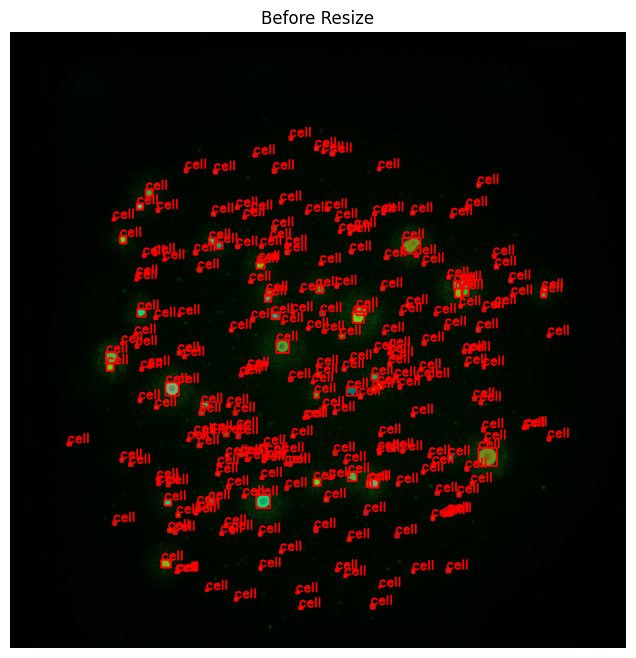

[Resize] before=248 kept=5 thr=(0.01818181818181818,0.01818181818181818) minwh=(0.003,0.003)


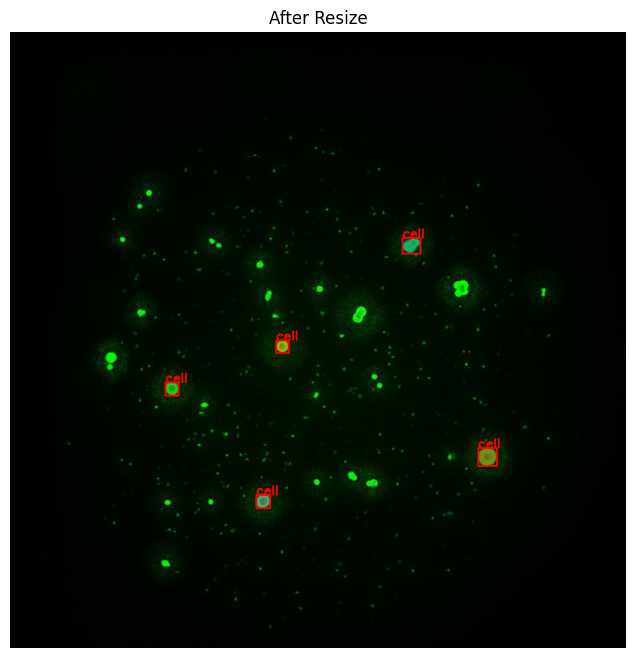

In [4]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지와 annotation 경로 지정
img_dir = "/home/mbd1234/data/yolo_set_3/images/val"
ann_path = "/home/mbd1234/data/yolo_set_3/annotations/instances_val.json"

# annotation 파일 로드
with open(ann_path, 'r') as f:
    coco_ann = json.load(f)

# COCO 형태에 맞게 category/id 매핑
catid2name = {cat['id']: cat['name'] for cat in coco_ann['categories']}
imgid2info = {img['id']: img for img in coco_ann['images']}

# 예시로 쓸 이미지 하나 고르기 (첫 번째)
img_info = coco_ann["images"][0]
img_id = img_info["id"]
img_filename = img_info["file_name"]
img_path = os.path.join(img_dir, img_filename)
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"이미지 파일을 찾을 수 없음: {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_h, img_w, _ = image.shape

# 해당 이미지에 해당하는 annotations 추출
anns = [ann for ann in coco_ann["annotations"] if ann["image_id"] == img_id]

# 마스크를 numpy 배열로 생성 (N, H, W)
def ann_to_mask(ann, height, width):
    """COCO annotation에서 segmenation(폴리곤) -> 바이너리 마스크"""
    from pycocotools import mask as maskUtils
    segmentation = ann["segmentation"]
    if isinstance(segmentation, list):
        # 폴리곤
        rles = maskUtils.frPyObjects(segmentation, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segmentation["counts"], list):
        # 언카운트 RLE
        rle = maskUtils.frPyObjects(segmentation, height, width)
    else:
        # COCO RLE
        rle = segmentation
    m = maskUtils.decode(rle)
    return m

n_objs = len(anns)
if n_objs == 0:
    raise RuntimeError("해당 이미지에 annotation이 없습니다.")
masks = np.zeros((n_objs, img_h, img_w), dtype=np.uint8)
boxes = []
labels = []

for i, ann in enumerate(anns):
    mask = ann_to_mask(ann, img_h, img_w)
    masks[i] = mask
    # COCO: [x, y, w, h] -> [x1, y1, x2, y2] 정규화(0~1)
    x, y, w, h = ann["bbox"]
    x1, y1, x2, y2 = x, y, x + w, y + h
    boxes.append([x1 / img_w, y1 / img_h, x2 / img_w, y2 / img_h])
    labels.append(ann["category_id"])

boxes = np.array(boxes, dtype=np.float32)
labels = np.array(labels)

# 원본 이미지 및 바운딩 박스/마스크 시각화 함수
def visualize(img, masks, boxes, labels, title):
    img_vis = img.copy()
    # mask overlay
    for idx, mask in enumerate(masks):
        color = np.array(plt.cm.tab10(idx % 10)[:3]) * 255
        img_vis[mask.astype(bool)] = 0.5 * img_vis[mask.astype(bool)] + 0.5 * color
    # bounding box
    for idx, (box, label) in enumerate(zip(boxes, labels)):
        # box: (x1, y1, x2, y2)
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = [int(v) for v in (x1, y1, x2, y2)]
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cat = catid2name[label]
        cv2.putText(img_vis, cat, (x1, max(10, y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.axis('off')
    plt.imshow(img_vis.astype(np.uint8))
    plt.show()

# (박스는 원래 정규화 상태이므로 복원)
boxes_abs = np.zeros_like(boxes)
boxes_abs[:, 0] = boxes[:, 0] * img_w
boxes_abs[:, 1] = boxes[:, 1] * img_h
boxes_abs[:, 2] = boxes[:, 2] * img_w
boxes_abs[:, 3] = boxes[:, 3] * img_h

visualize(image, masks, boxes_abs, labels, "Before Resize")

# Resize 적용
resize = Resize()
resized_img, resized_masks, resized_boxes, resized_labels = resize(
    image.copy(),
    masks.copy(),
    boxes.copy(),
    labels.copy()
)

# 변환된 것 시각화 (마스크: (N, H, W), 박스: 정규화된 값 -> 절대좌표로 변환)
resized_h, resized_w, _ = resized_img.shape
boxes_abs_resize = np.zeros_like(resized_boxes)
boxes_abs_resize[:, 0] = resized_boxes[:, 0] * resized_w
boxes_abs_resize[:, 1] = resized_boxes[:, 1] * resized_h
boxes_abs_resize[:, 2] = resized_boxes[:, 2] * resized_w
boxes_abs_resize[:, 3] = resized_boxes[:, 3] * resized_h

visualize(resized_img, resized_masks, boxes_abs_resize, resized_labels, "After Resize")



In [2]:
# Let's load the CSV the user mentioned and take a look at its columns.
import pandas as pd
from pathlib import Path

csv_path = Path("/home/mbd1234/data/cellposlized_data/summary_by_json.csv")
df = pd.read_csv(csv_path)

# Show a small preview and the column names for transparency.
preview = df.head(20)

df.columns.tolist()


['stem',
 'instances',
 'total_area_px',
 'small_count',
 'small_area_px',
 'medium_count',
 'medium_area_px',
 'large_count',
 'large_area_px',
 'min_area_px',
 'max_area_px',
 'small_mean_area_px',
 'medium_mean_area_px',
 'large_mean_area_px']

Cell size distribution summary (small/medium/large)                      small     medium    large
metric                                        
count            440733.00     425.00      4.0
area_px        39881015.00  799847.00  39799.0
count_share_%        99.90       0.10      0.0
area_share_%         97.94       1.96      0.1


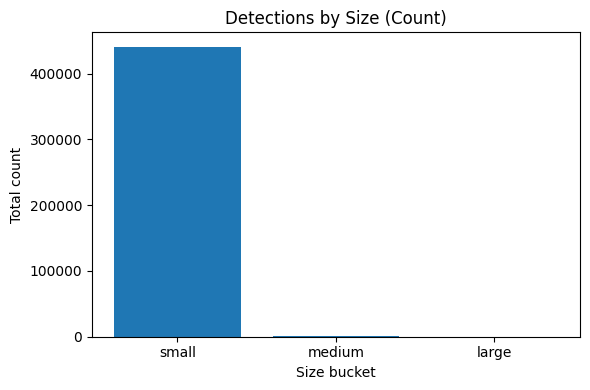

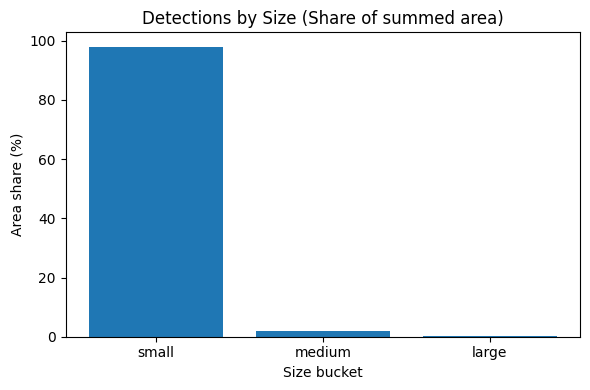

Per-image dominant size bucket                  num_images
dominant_bucket            
small                   973
none                     26
medium                    1


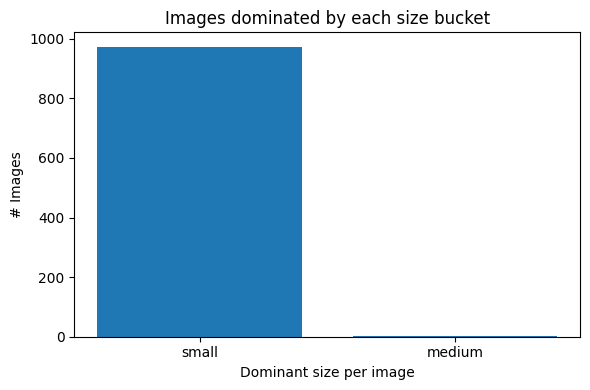

Average per-image mean area (px) by size bucket                   small   medium    large
avg_mean_area_px  93.54  1951.47  9949.75


'/home/mbd1234/data/result_report/400_result/cell_size_distribution_report.txt'

In [ ]:
# Aggregate small/medium/large distributions across the whole dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("")

# Replace potential NaNs with zeros for counts/areas
for col in [
    "small_count","medium_count","large_count",
    "small_area_px","medium_area_px","large_area_px",
    "instances","total_area_px"
]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

total_counts = {
    "small": int(df["small_count"].sum()),
    "medium": int(df["medium_count"].sum()),
    "large": int(df["large_count"].sum()),
}
total_area = {
    "small": float(df["small_area_px"].sum()),
    "medium": float(df["medium_area_px"].sum()),
    "large": float(df["large_area_px"].sum()),
}

# Percent shares
count_sum = sum(total_counts.values())
area_sum = sum(total_area.values()) if sum(total_area.values()) > 0 else 1.0

count_share = {k: (v / count_sum * 100.0) if count_sum else 0.0 for k, v in total_counts.items()}
area_share  = {k: (v / area_sum  * 100.0) if area_sum  else 0.0 for k, v in total_area.items()}

# Build a summary table
summary = pd.DataFrame({
    "metric": ["count","area_px","count_share_%","area_share_%"],
    "small": [total_counts["small"], total_area["small"], count_share["small"], area_share["small"]],
    "medium":[total_counts["medium"], total_area["medium"], count_share["medium"], area_share["medium"]],
    "large": [total_counts["large"], total_area["large"], count_share["large"], area_share["large"]],
}).set_index("metric")

print("Cell size distribution summary (small/medium/large)", summary.round(2))

# Bar chart: counts per size
sizes = ["small","medium","large"]
counts = [total_counts[s] for s in sizes]

plt.figure(figsize=(6,4))
plt.bar(sizes, counts)
plt.title("Detections by Size (Count)")
plt.xlabel("Size bucket")
plt.ylabel("Total count")
plt.tight_layout()
plt.show()

# Bar chart: area share per size
shares = [area_share[s] for s in sizes]

plt.figure(figsize=(6,4))
plt.bar(sizes, shares)
plt.title("Detections by Size (Share of summed area)")
plt.xlabel("Size bucket")
plt.ylabel("Area share (%)")
plt.tight_layout()
plt.show()

# Additional per-image trend: which size dominates per image?
def dominant_bucket(row):
    counts = {"small":row.get("small_count",0), "medium":row.get("medium_count",0), "large":row.get("large_count",0)}
    # If all zero, return none
    if max(counts.values()) == 0:
        return "none"
    return max(counts, key=counts.get)

df["dominant_bucket"] = df.apply(dominant_bucket, axis=1)
dominance_counts = df["dominant_bucket"].value_counts(dropna=False).to_dict()

dom_summary = pd.DataFrame.from_dict(dominance_counts, orient="index", columns=["num_images"]).rename_axis("dominant_bucket")
print("Per-image dominant size bucket", dom_summary)

# Chart: number of images dominated by each bucket (excluding 'none')
dom_for_chart = {k:v for k,v in dominance_counts.items() if k != "none"}
plt.figure(figsize=(6,4))
plt.bar(list(dom_for_chart.keys()), list(dom_for_chart.values()))
plt.title("Images dominated by each size bucket")
plt.xlabel("Dominant size per image")
plt.ylabel("# Images")
plt.tight_layout()
plt.show()

# Compute average mean area per bucket (if available)
mean_cols = ["small_mean_area_px","medium_mean_area_px","large_mean_area_px"]
available_means = [c for c in mean_cols if c in df.columns]
mean_summary = None
if available_means:
    mean_vals = {
        "small": float(df["small_mean_area_px"].replace(0, np.nan).mean(skipna=True)),
        "medium": float(df["medium_mean_area_px"].replace(0, np.nan).mean(skipna=True)),
        "large": float(df["large_mean_area_px"].replace(0, np.nan).mean(skipna=True)),
    }
    mean_summary = pd.DataFrame({"avg_mean_area_px": mean_vals}).T
    print("Average per-image mean area (px) by size bucket", mean_summary.round(2))

# Save a concise text report to a file for download
report_lines = []
report_lines.append("Cell Size Distribution Report\n")
report_lines.append(f"Total instances: {int(df['instances'].sum())}\n")
report_lines.append(f"Counts -> small: {total_counts['small']}, medium: {total_counts['medium']}, large: {total_counts['large']}\n")
report_lines.append(f"Count share (%) -> small: {count_share['small']:.2f}, medium: {count_share['medium']:.2f}, large: {count_share['large']:.2f}\n")
report_lines.append(f"Area share (%)  -> small: {area_share['small']:.2f}, medium: {area_share['medium']:.2f}, large: {area_share['large']:.2f}\n")
if mean_summary is not None:
    report_lines.append("Average mean area px (per image where present):\n")
    for k in ["small","medium","large"]:
        report_lines.append(f"  - {k}: {mean_vals[k]:.2f}\n")

# Dominant bucket stats
dom_order = ["small","medium","large","none"]
for k in dom_order:
    if k in dominance_counts:
        report_lines.append(f"Images dominated by {k}: {dominance_counts[k]}\n")

report_path = "/home/mbd1234/data/result_report/400_result/cell_size_distribution_report.txt"
with open(report_path, "w") as f:
    f.writelines(report_lines)

report_path


Counts: {'small': 440733, 'medium': 425, 'large': 4}  (share %) {'small': 99.903, 'medium': 0.096, 'large': 0.001}
Area  : {'small': 39881015, 'medium': 799847, 'large': 39799}  (share %) {'small': 97.938, 'medium': 1.964, 'large': 0.098}
Dominant buckets per image:
 small     973
none       26
medium      1
Name: count, dtype: int64


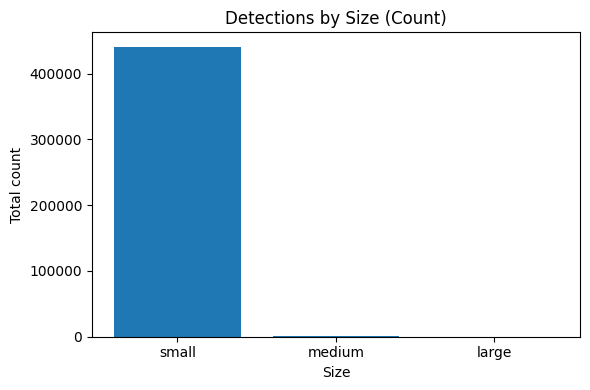

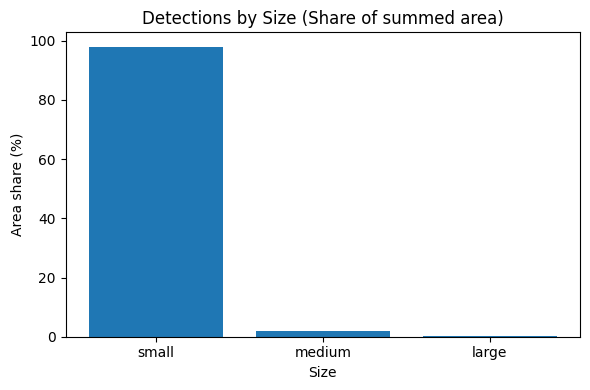

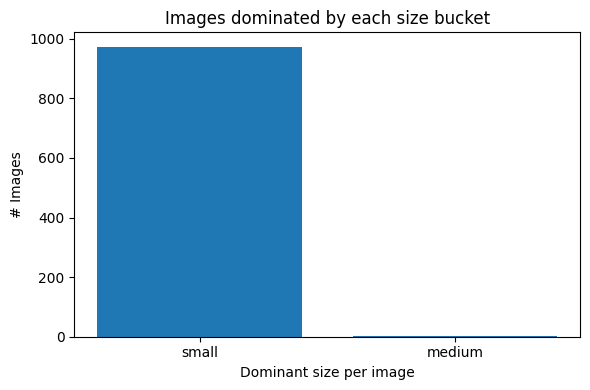

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/home/mbd1234/data/cellposlized_data/summary_by_json.csv").fillna(0)

# 전체 합계
tot = {
    "small": int(df["small_count"].sum()),
    "medium": int(df["medium_count"].sum()),
    "large": int(df["large_count"].sum()),
}
area = {
    "small": float(df["small_area_px"].sum()),
    "medium": float(df["medium_area_px"].sum()),
    "large": float(df["large_area_px"].sum()),
}
cnt_sum  = sum(tot.values()) or 1
area_sum = sum(area.values()) or 1

# 비율
cnt_share  = {k: 100*tot[k]/cnt_sum for k in tot}
area_share = {k: 100*area[k]/area_sum for k in area}

print("Counts:", tot, " (share %)", {k: round(v,3) for k,v in cnt_share.items()})
print("Area  :", {k:int(v) for k,v in area.items()}, " (share %)", {k: round(v,3) for k,v in area_share.items()})

# 이미지별 지배 버킷
def dominant(row):
    vals = {"small":row.small_count, "medium":row.medium_count, "large":row.large_count}
    return max(vals, key=vals.get) if max(vals.values())>0 else "none"
dom = df.apply(dominant, axis=1).value_counts()
print("Dominant buckets per image:\n", dom)

# 그래프 1: 개수
plt.figure(figsize=(6,4))
plt.bar(["small","medium","large"], [tot["small"], tot["medium"], tot["large"]])
plt.title("Detections by Size (Count)"); plt.xlabel("Size"); plt.ylabel("Total count")
plt.tight_layout(); plt.show()

# 그래프 2: 면적 비중
plt.figure(figsize=(6,4))
plt.bar(["small","medium","large"], [area_share["small"], area_share["medium"], area_share["large"]])
plt.title("Detections by Size (Share of summed area)"); plt.xlabel("Size"); plt.ylabel("Area share (%)")
plt.tight_layout(); plt.show()

# 그래프 3: 이미지 지배 버킷 개수(‘none’ 제외)
dom_ = dom.drop(labels=["none"], errors="ignore")
plt.figure(figsize=(6,4))
plt.bar(dom_.index.tolist(), dom_.values.tolist())
plt.title("Images dominated by each size bucket"); plt.xlabel("Dominant size per image"); plt.ylabel("# Images")
plt.tight_layout(); plt.show()
